## Source of data 
Source: https://archive.ics.uci.edu/ml/datasets/Wholesale+customers

Margarida G. M. S. Cardoso, margarida.cardoso '@' iscte.pt, ISCTE-IUL, Lisbon, Portugal


Data Set Information:

Provide all relevant information about your data set.


Attribute Information:

    1) FRESH: annual spending (m.u.) on fresh products (Continuous);
    2) MILK: annual spending (m.u.) on milk products (Continuous);
    3) GROCERY: annual spending (m.u.)on grocery products (Continuous);
    4) FROZEN: annual spending (m.u.)on frozen products (Continuous)
    5) DETERGENTS_PAPER: annual spending (m.u.) on detergents and paper products (Continuous)
    6) DELICATESSEN: annual spending (m.u.)on and delicatessen products (Continuous);
    7) CHANNEL: customers  Channel - Horeca (Hotel/Restaurant/CafÃ©) or Retail channel (Nominal)
    8) REGION: customers  Region Lisnon, Oporto or Other (Nominal)
 

Relevant Papers:

## Exploratry Data Analysis 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv(filepath_or_buffer='../DATA/wholesome_customers_data.csv')

In [3]:
df.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Channel           440 non-null    int64
 1   Region            440 non-null    int64
 2   Fresh             440 non-null    int64
 3   Milk              440 non-null    int64
 4   Grocery           440 non-null    int64
 5   Frozen            440 non-null    int64
 6   Detergents_Paper  440 non-null    int64
 7   Delicassen        440 non-null    int64
dtypes: int64(8)
memory usage: 27.6 KB


No,  data is mssing! Let's explore some relationsip between continuous varaibles

In [5]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Channel,440.0,1.322727,0.468052,1.0,1.00,1.0,2.00,2.0
Region,440.0,2.543182,0.774272,1.0,2.00,3.0,3.00,3.0
Fresh,440.0,12000.297727,12647.328865,3.0,3127.75,8504.0,16933.75,112151.0
Milk,440.0,5796.265909,7380.377175,55.0,1533.00,3627.0,7190.25,73498.0
Grocery,440.0,7951.277273,9503.162829,3.0,2153.00,4755.5,10655.75,92780.0
Frozen,440.0,3071.931818,4854.673333,25.0,742.25,1526.0,3554.25,60869.0
Detergents_Paper,440.0,2881.493182,4767.854448,3.0,256.75,816.5,3922.00,40827.0
Delicassen,440.0,1524.870455,2820.105937,3.0,408.25,965.5,1820.25,47943.0


<Axes: xlabel='Milk', ylabel='Grocery'>

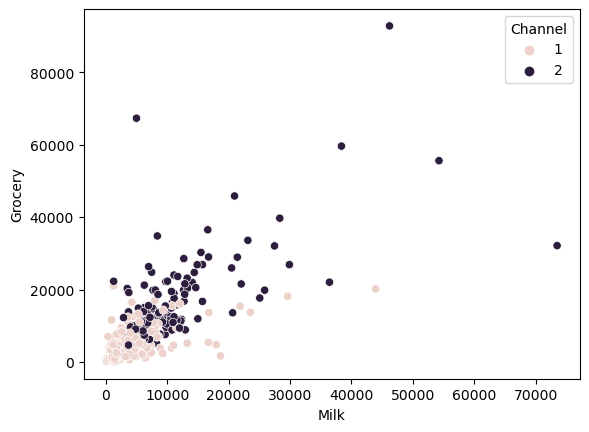

In [6]:
sns.scatterplot(data=df, x='Milk', y='Grocery', hue='Channel')

There is a linear relationship with some outliers 

<Axes: xlabel='Milk', ylabel='Count'>

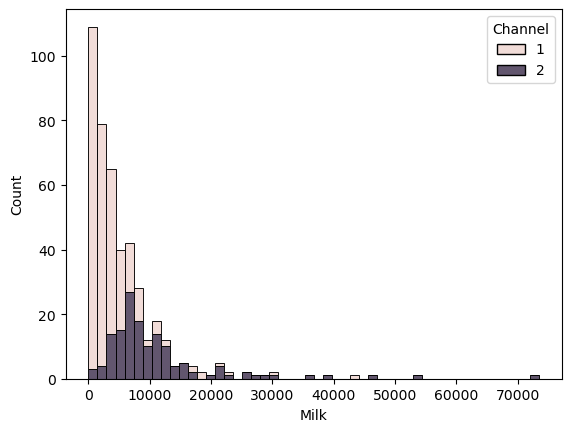

In [7]:
sns.histplot(data=df, x='Milk', hue='Channel', multiple='stack')

Looks more like a exopnential distribution.

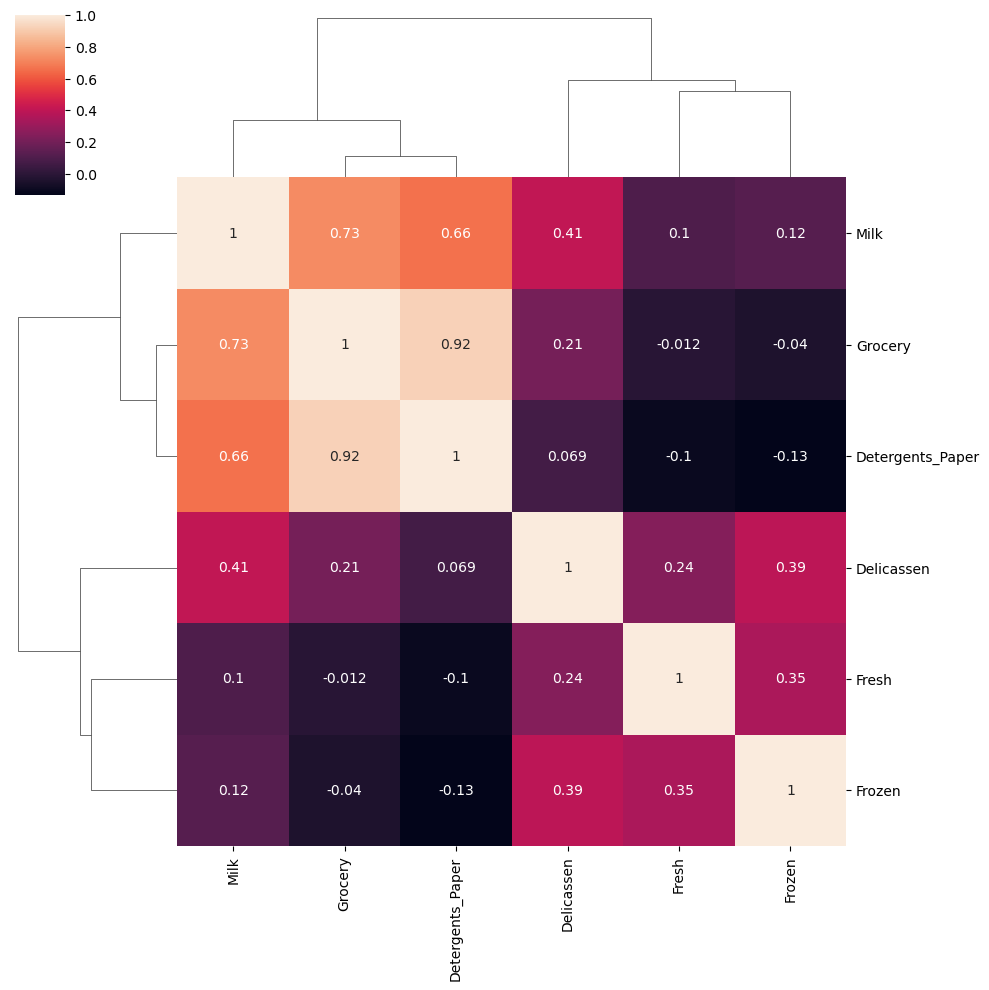

In [8]:
sns.clustermap(data=df.iloc[:,2:].corr(), annot=True)

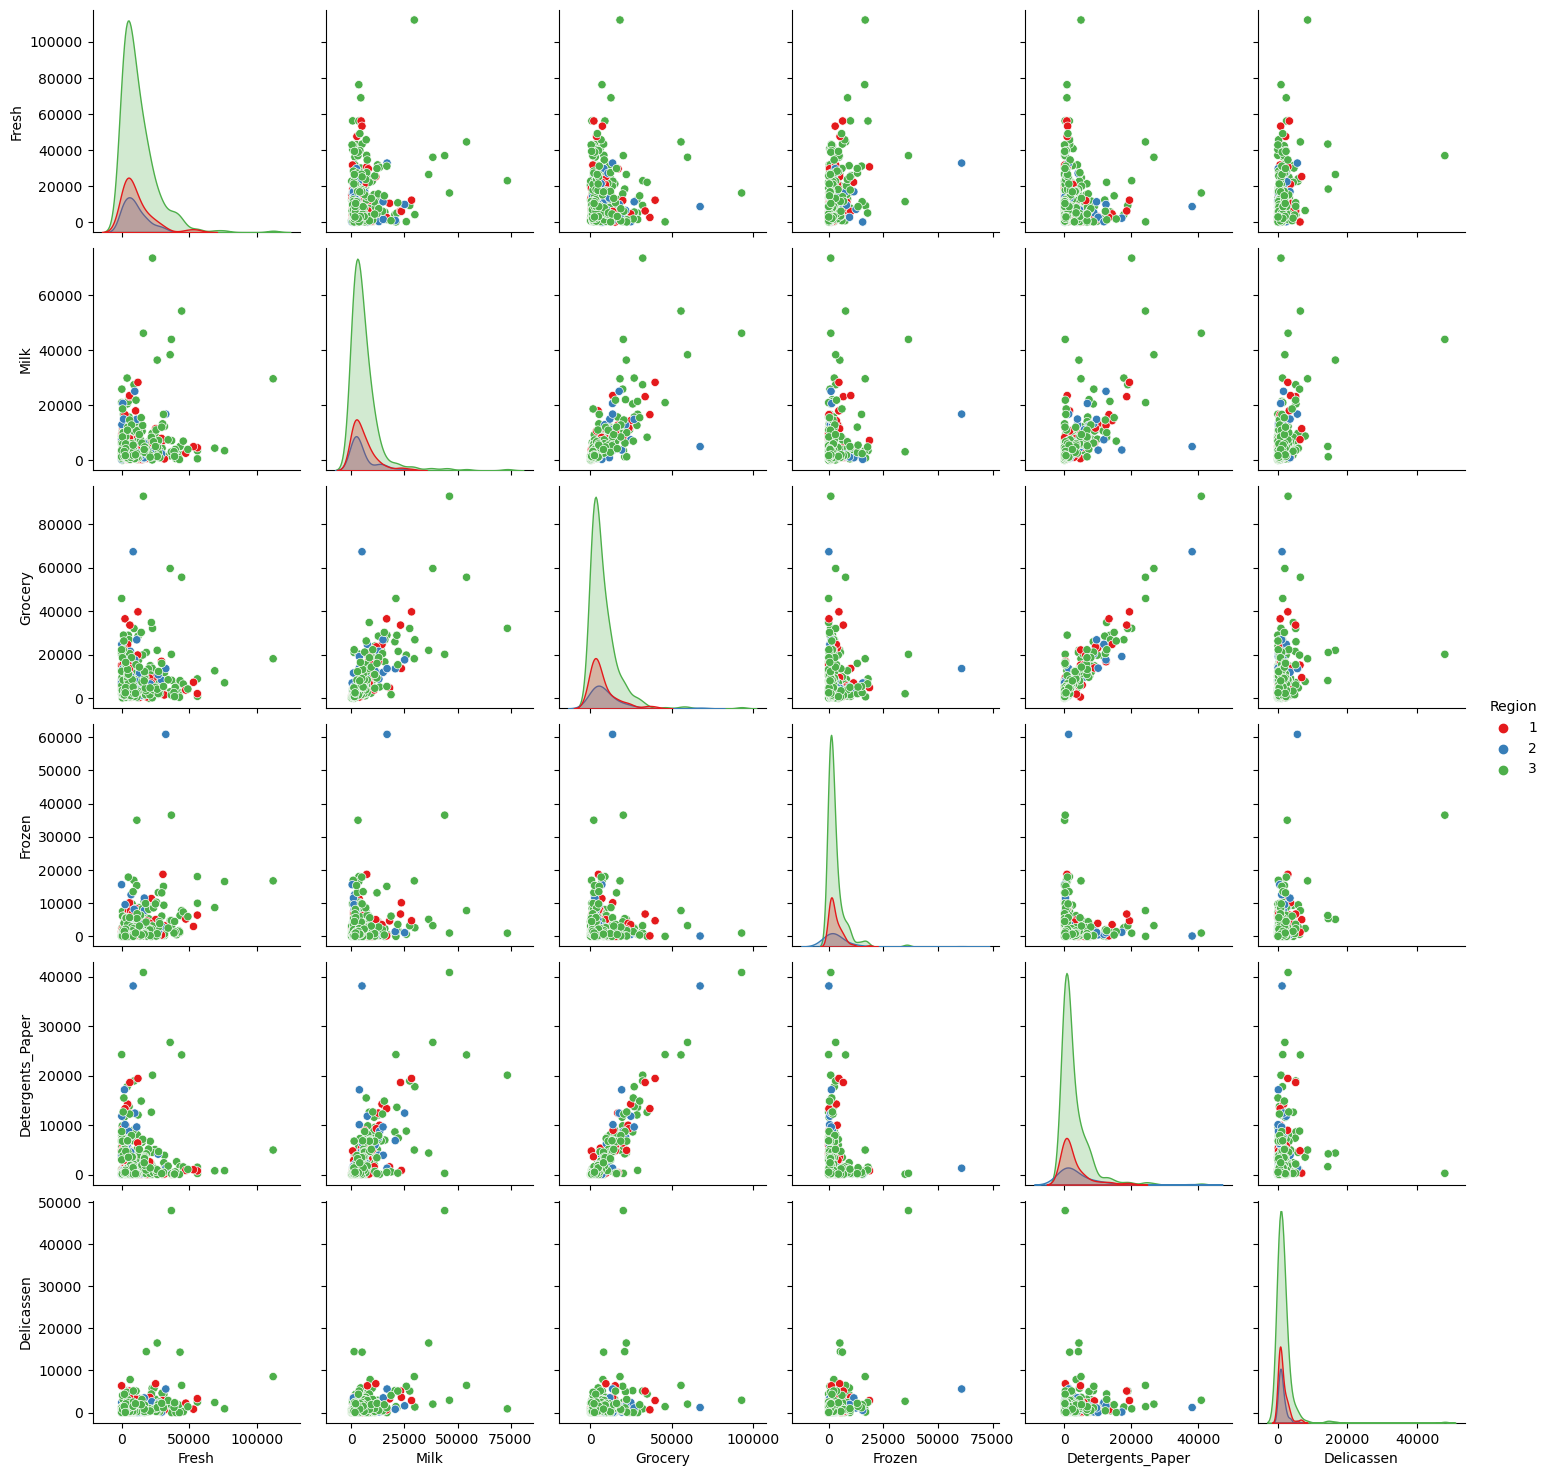

In [9]:
sns.pairplot(data=df , hue='Region', vars=df.columns[2:], palette='Set1')

## Data Preprocessing 

In [25]:
from sklearn.preprocessing import StandardScaler

X = df
scaler = StandardScaler()

X_scaled  = scaler.fit_transform(X=X)

In [26]:
# Get esp vs outlier plot 
def scan_dbscan_epsilon(scaled_X , minsample: int = 5  ,eps = np.linspace(0.001, 3, 100), hline: float =1):
    """Scans for a point of inflexion for DBSCAN. Plots eps  vs perct of outliner.

    Plots eps vs outlier % for dbscan. 

    Parameters
    ----------
    scaled_X
        Scaled feature data.
    minsample
        The value of minsample is 5 by default. Use dim(feature) * 2 for good performance.
    eps, optional
        Range of eps value to search, by default np.linspace(0.001, 3, 100)
    hline, optional
        generates a horizontal like at a given outlier percentage, by default 1
    """    """"""   
    
    from sklearn.cluster import DBSCAN
    outlier = []
    for epsilon in eps:
        model = DBSCAN(eps=epsilon , min_samples= minsample, n_jobs=-1)
        model.fit(X_scaled)
        outlier.append(np.sum(model.labels_  == -1))
    outlier_perct = np.array(outlier) * 100/len(model.labels_)

    plt.figure(figsize=(10,6), dpi=150)
    plt.grid(visible=True, which='both', axis='both')
    plt.plot(eps, outlier_perct)
    plt.ylabel('outlier percentage')
    plt.xlabel('epsilon')
    plt.hlines(y=hline, xmax=eps[-1], xmin=eps[0], linestyles='--', label= '1% Outlier', colors='green')
    plt.show()


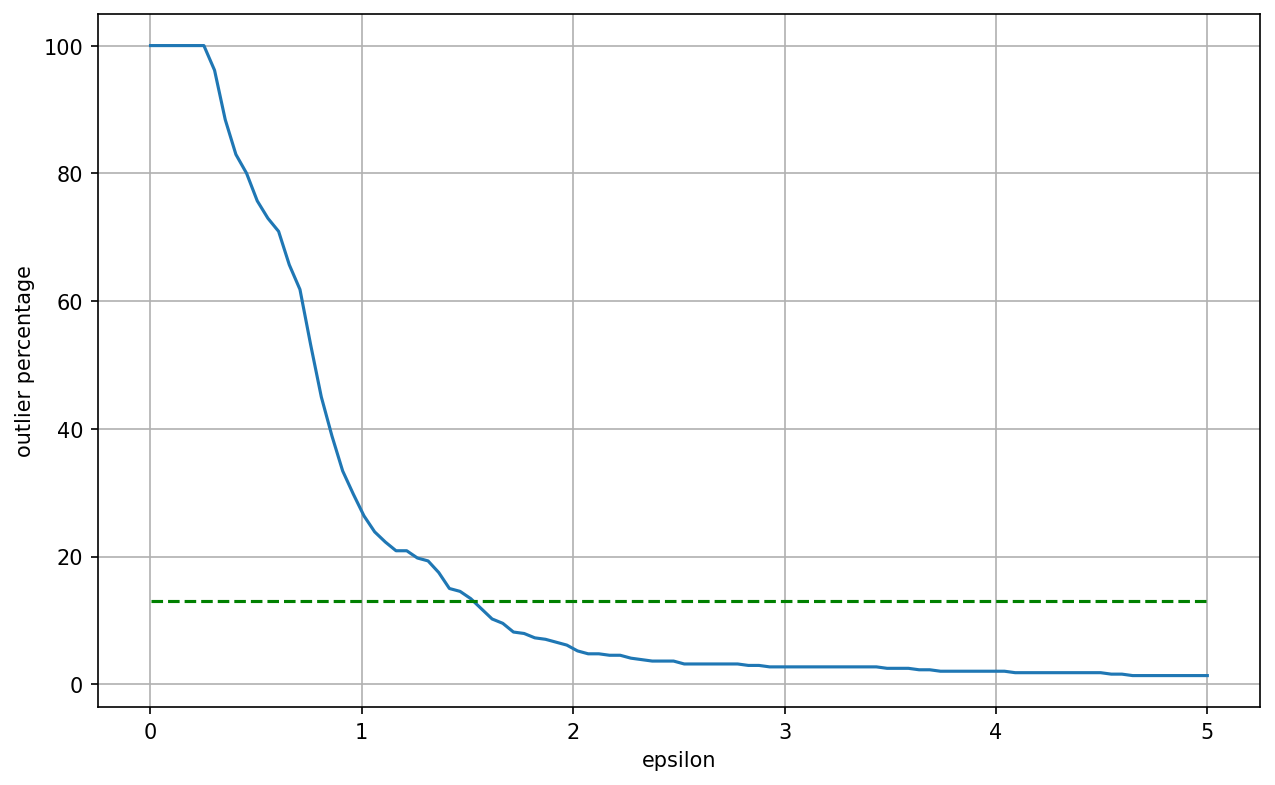

In [27]:
scan_dbscan_epsilon(X_scaled, 2* len(df.columns), eps=np.linspace(0.001, 5, 100) ,  hline=13)

Looks like outliers settles down an esp = 2. Let's retrain the model to account this.

In [33]:
from sklearn.cluster import DBSCAN

model = DBSCAN(eps=2, min_samples=2 * len(df.columns))

In [34]:
model.fit(X_scaled)

DBSCAN(eps=2, min_samples=16)

How many cluster points did the DBSCAN discover?

In [35]:
set(model.labels_)

{-1, 0, 1}

Seems like 2 clusters were discovered

## Cluster Interpretation

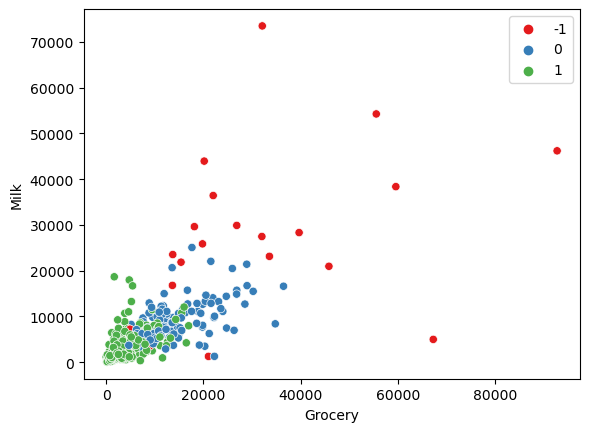

In [36]:
sns.scatterplot(data=df, x='Grocery', y='Milk', hue=model.labels_, palette='Set1');

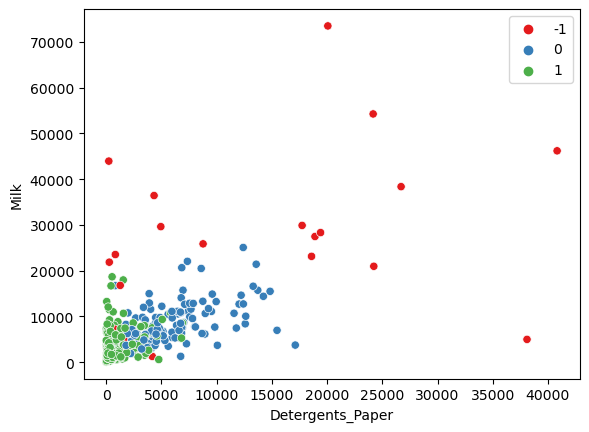

In [37]:
sns.scatterplot(data=df, x='Detergents_Paper', y='Milk', hue=model.labels_, palette='Set1');

In [38]:
df['Lables'] = model.labels_

Let's see the statistical difference between the cluster.

In [52]:
mean_dist_over_lable = df.groupby(by='Lables').mean().iloc[:,2:]

In [56]:
from sklearn.preprocessing import MinMaxScaler

mean_dist_over_lable_normalize = MinMaxScaler().fit_transform(mean_dist_over_lable)
mean_dist_over_lable_normalize = pd.DataFrame(data=mean_dist_over_lable_normalize , index=mean_dist_over_lable.index, columns=mean_dist_over_lable.columns)

<Axes: ylabel='Lables'>

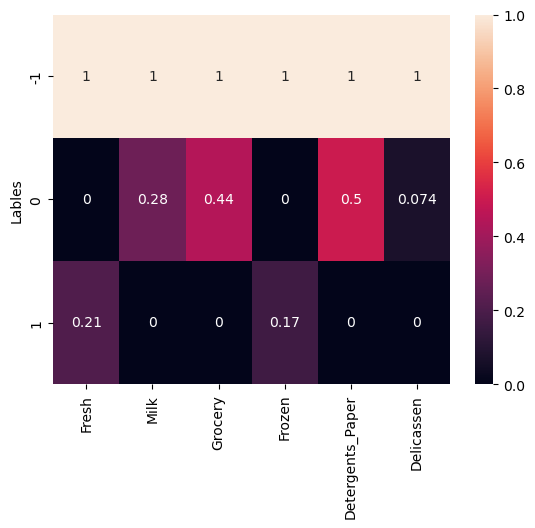

In [59]:
sns.heatmap(data=mean_dist_over_lable_normalize)

Outlier have heavy spending on all the features

<Axes: ylabel='Lables'>

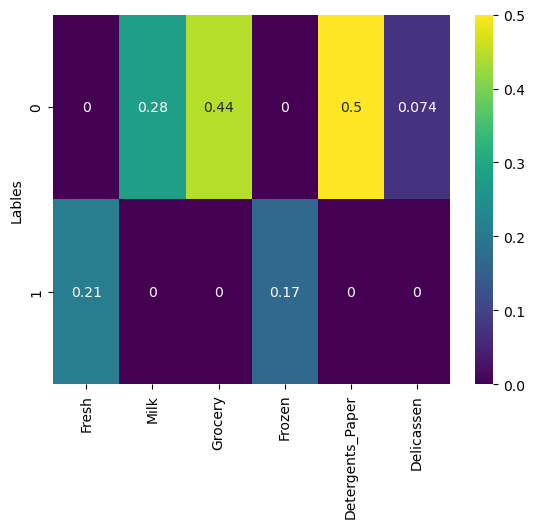

In [63]:
sns.heatmap(data=mean_dist_over_lable_normalize.iloc[1:,:], annot=True, cmap='viridis')

In [62]:
mean_dist_over_lable

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
Lables,,,,,,
-1,27729.920000,22966.960000,26609.600000,11289.640000,11173.560000,6707.160000
0,8227.666667,8615.852713,13859.674419,1447.759690,5969.581395,1498.457364
1,12326.972028,3023.559441,3655.328671,3086.181818,763.783217,1083.786713
